In [1]:
# install on first run
# python -m venv .venv,,
# pip install -r requirements

from dotenv import load_dotenv

from langchain_community.llms import HuggingFaceEndpoint
from langchain_core.prompts import PromptTemplate

from typing import List
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser

from readability import Readability
from readability.exceptions import ReadabilityException

load_dotenv()

True

### Model and Chain

In [2]:
hub = HuggingFaceEndpoint(repo_id="NousResearch/Nous-Hermes-2-Mixtral-8x7B-DPO")

c:\Users\alanj\Documents\GitHub\dynolearn\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to C:\Users\alanj\.cache\huggingface\token
Login successful


In [11]:
tasks_template = """<|im_start|>system
As a seasoned game designer with expertise in creating engaging educational content for children, 
I challenge you to craft a JSON list of 10 captivating game scene tasks and prompts that will help children with autism master what they are learning.
Please present each task and prompt as a JSON list item, with a clear description that will motivate and engage young learners. 
Your tasks should be designed to gradually increase in difficulty, with a mix of fun and challenging activities that cater to different learning styles.
A childs reading level is a measure of how easy a text is to read. It is usually measured in years, so a reading level of 5 means that a 5 year old can read it. 
If a child is struggling with reading, they may have a reading level that is lower than their actual age.<|im_end|>
<|im_start|>user
{name} is {age} years old and has a reading level age of {reading_level}. They need help with learning {teaching_task}.

Please make a list of 10 suitable game scene tasks and prompts to learn {teaching_task}.

Just list out each item 1 by 1 in a JSON list. Do not include the question or any other information, just the list in JSON.<|im_end|>
<|im_start|>assistant
Here is a JSON list of 10 game scene tasks and prompts to help {name} with learning {teaching_task}:
"""

class Tasks(BaseModel):
    tasks: List = Field(description="list of game scene tasks")


parser = JsonOutputParser(pydantic_object=Tasks)

tasks_prompt_json = PromptTemplate(
    template=tasks_template,
    input_variables=["name", "age", "reading_level", "teaching_task"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

tasks_chain = tasks_prompt_json | hub | parser

In [12]:
# tasks_chain.invoke(
#     {
#         "name": "Alice",
#         "age": 8,
#         "reading_level": 5,
#         "teaching_task": "The colours in the rainbow",
#     }
# )

[{'task': 'Rainbow Race',
  'prompt': 'Join the rainbow race! Help a character run through the rainbow by selecting the correct color at each checkpoint. As you progress, the game will become faster and the colors will be displayed in a random order.'},
 {'task': 'Color Sorting',
  'prompt': 'Sort the rainbow! Organize rainbow-colored fruits, toys, or other objects into their respective color groups. As you advance, the number of items and the variety of colors will increase.'},
 {'task': 'Color Matching',
  'prompt': 'Match the colors! Find the two items that have the same rainbow color and match them together. The game will become more challenging as the number of items and colors increase.'},
 {'task': 'Color Memory',
  'prompt': 'Test your memory! Memorize the order of the colors in the rainbow, and then recreate the sequence by selecting the correct color cards. The game will become more difficult as the number of colors increases and the sequence becomes longer.'},
 {'task': 'Rai

### Wrappers

In [5]:
def spache_wrapper(rd: Readability):
    try:
        return rd.spache().score
    except ReadabilityException:
        return -1

def flesch_wrapper(rd: Readability):
    try:
        return rd.flesch().score
    except ReadabilityException:
        return -1

def flesch_kincaid_wrapper(rd: Readability):
    try:
        return rd.flesch_kincaid().score
    except ReadabilityException:
        return -1


def ari_wrapper(rd: Readability):
    try:
        return rd.ari().score
    except ReadabilityException:
        return -1


def coleman_liau_wrapper(rd: Readability):
    try:
        return rd.coleman_liau().score
    except ReadabilityException:
        return -1


def dale_chall_wrapper(rd: Readability):
    try:
        return rd.dale_chall().score
    except ReadabilityException:
        return -1


def gunning_fog_wrapper(rd: Readability):
    try:
        return rd.gunning_fog().score
    except ReadabilityException:
        return -1


def linsear_write_wrapper(rd: Readability):
    try:
        return rd.linsear_write().score
    except ReadabilityException:
        return -1


def smog_wrapper(rd: Readability):
    try:
        return rd.smog(all_sentences=True).score
    except ReadabilityException:
        return -1

def statistics_wrapper(rd: Readability):
    try:
        return rd.statistics()
    except ReadabilityException:
        return -1

## Prompts

In [1]:
teaching_tasks = [
    "How to get ready for school",
    "How to identify shapes",
    "How to read body language",
    "How to understand facial expressions",
    "How to share with others",
    "How to empathise with others",
    "How to handle identify emotions",
    "How to deal with emotions",
    "How to spell their name",
    "How to solve a maze",
    "How to tidy up",
    "How to ask for help",
    "How to brush teeth",
    "How to use the toilet",
    "How to deal with loud noises",
    "How to deal with bright lights",
    "How to deal with strong smells",
    "How to make friends",
    "How to help others",
]

## Evaluation

In [2]:
input_params = [
    "name", "age", "reading_level", "teaching_task"
]

readability_evaluators = [
    "spache", "flesch", "flesch_kincaid", "ari", "coleman_liau", "dale_chall", "gunning_fog", "linsear_write", "smog"
]

statistics_keys = [
    "num_letters", "num_words", "num_sentences", "num_polysyllabic_words", "avg_words_per_sentence", "avg_syllables_per_word"
]

In [4]:
def evaluate_tasks(llm_input, output_file):
    eval_results = []

    with open(output_file, "a") as f:
        # Write the header
        f.writelines(f"{'\t'.join(input_params)}\tLLM Output\t{'\t'.join(readability_evaluators)}\t{'\t'.join(statistics_keys)}\n")
        
        # Loop through the teach tasks
        for teaching_task in teaching_tasks:

            llm_input["teaching_task"] = teaching_task
            
            try:
                llm_output = tasks_chain.invoke(llm_input)
            except (Exception) as e:
                print(e)
                try:
                    llm_output = tasks_chain.invoke(llm_input)
                except (Exception) as e:
                    print(e)
                    continue

            print(llm_output)

            # Parse the output
            rd = Readability(str(llm_output))

            scores = {
                "spache": spache_wrapper(rd),
                "flesch": flesch_wrapper(rd),
                "flesch_kincaid": flesch_kincaid_wrapper(rd),
                "ari": ari_wrapper(rd),
                "coleman_liau": coleman_liau_wrapper(rd),
                "dale_chall": dale_chall_wrapper(rd),
                "gunning_fog": gunning_fog_wrapper(rd),
                "linsear_write": linsear_write_wrapper(rd),
                "smog": smog_wrapper(rd),
            }
            
            statistics = statistics_wrapper(rd)
            
            input_params_str = "\t".join([str(llm_input[param]) for param in input_params])
            scores_str = "\t".join([str(scores[evaluator]) for evaluator in readability_evaluators])
            statistics_keys_str = "\t".join([str(statistics[key]) for key in statistics_keys])
                
            eval_results.append({
                "llm_input": llm_input,
                "llm_output": llm_output,
                "scores": scores
            })

            f.writelines(f"{input_params_str}\t{llm_output}\t{scores_str}\t{statistics_keys_str}\n")
    return eval_results

In [ ]:
evaluation_william_results = evaluate_tasks(
    {
        "name": "William",
        "age": 7,
        "reading_level": 5,
    },
    "evaluation_william.tsv"
)

In [22]:
evaluation_sophie_results = evaluate_tasks(
    {
        "name": "Sophie",
        "age": 7,
        "reading_level": 5,
    },
    "evaluation_sophie.tsv"
)

[{'task': 'Brush your teeth', 'prompt': 'Use your toothbrush and toothpaste to brush your teeth for two minutes. Remember to brush all the surfaces of your teeth.'}, {'task': 'Pick out your outfit', 'prompt': 'Choose a comfortable and appropriate outfit for the day. Make sure it is clean and weather-appropriate.'}, {'task': 'Pack your backpack', 'prompt': 'Put all your necessary school supplies, such as books, pencils, and lunch, in your backpack. Check to make sure you have everything you need.'}, {'task': 'Make your bed', 'prompt': 'Smooth out your bed sheets and blankets, and tuck them in neatly. Place your pillows at the head of your bed.'}, {'task': 'Eat a healthy breakfast', 'prompt': 'Choose a nutritious breakfast, such as whole-grain cereal, fruit, and yogurt. Make sure to eat a balanced meal to start your day off right.'}, {'task': 'Groom your hair', 'prompt': 'Brush or comb your hair to make sure it is neat and tidy. If you wear a hair tie, secure your hair in place.'}, {'tas

In [23]:
evaluation_reading_level_10_results = evaluate_tasks(
    {
        "name": "William",
        "age": 7,
        "reading_level": 10,
    },
    "evaluation_reading_level_10.tsv"
)

[{'task': 'Dressing Task', 'prompt': 'Put on your clothes for school. Start with your socks and underwear, then your shirt, pants, and shoes. Make sure everything matches and is appropriate for school.'}, {'task': 'Brushing Teeth Task', 'prompt': 'Brush your teeth for 2 minutes. Make sure to use toothpaste and brush all the surfaces of your teeth.'}, {'task': 'Combing Hair Task', 'prompt': 'Comb your hair neatly and style it in a way you like. You can also put on a headband or hair tie if you prefer.'}, {'task': 'Packing Lunch Task', 'prompt': 'Prepare a healthy lunch for school. Choose a sandwich, fruit, vegetable, and a snack. Make sure you have a drink to go with it.'}, {'task': 'Gathering School Supplies Task', 'prompt': 'Gather all your school supplies like pencils, erasers, notebooks, and textbooks. Put them in your backpack so you have everything you need for the day.'}, {'task': 'Setting Alarm Task', 'prompt': 'Set your alarm to wake up at a specific time. Make sure you have en

In [24]:
evaluation_age_10_results = evaluate_tasks(
    {
        "name": "William",
        "age": 10,
        "reading_level": 5,
    },
    "evaluation_age_10.tsv"
)

[{'Task': 'Match the Clothing', 'Description': 'Drag and drop the clothing items to their corresponding outfit in the closet. This will help William learn how to choose appropriate clothes for school.'}, {'Task': 'Pack the Bag', 'Description': "Drag and drop the necessary items into William's backpack. This will teach William how to pack their bag with essentials for school."}, {'Task': 'Brush Your Teeth', 'Description': 'Help William brush their teeth by guiding the toothbrush to each tooth. This will reinforce good oral hygiene habits.'}, {'Task': 'Tie Your Shoes', 'Description': 'Watch the step-by-step guide on how to tie shoes and practice tying them with William. This will teach them a useful life skill.'}, {'Task': 'Eat a Healthy Breakfast', 'Description': 'Choose healthy breakfast options for William to eat before school. This will teach them the importance of a nutritious meal to start the day.'}, {'Task': 'Put on Your Shoes', 'Description': 'Help William put on their shoes by 

[{'Task': 'Task 1: Picture Prompt', 'Description': 'Look at a picture of someone experiencing a strong emotion. What do you think they might be feeling? Why do you think they feel that way?', 'Reading Level': '5'}, {'Task': 'Task 2: Social Story', 'Description': 'Read a social story about a child experiencing a difficult situation. How do you think the child feels? What would you do to help them?', 'Reading Level': '5'}, {'Task': 'Task 3: Role-Play', 'Description': 'Pretend to be a friend who needs help. Tell the other player what you are feeling and why. Have them respond with empathy and offer support.', 'Reading Level': '5'}, {'Task': 'Task 4: Empathy Cards', 'Description': 'Pick a card with an emotion on it. Think of a time when you felt that emotion. Share your experience with the group and have them respond with empathy.', 'Reading Level': '5'}, {'Task': 'Task 5: Storytelling', 'Description': 'Create a short story about a character going through a difficult time. As a group, disc

## Graph Results

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
def graph_results(ds_filename):
    ds = pd.read_csv(ds_filename, sep="\t")
    ds.head()
    
    # replace -1 with NaN
    ds = ds.replace(-1, np.nan)
    # ignore evaluators that were all NaN
    ds = ds.dropna(axis=1, how='all')
    
    index_range = range(ds.index.stop)
    
    plt.bar(index_range, ds["spache"])
    plt.title("Spache Readability Score")
    plt.xlabel("Prompts")
    plt.ylabel("Score")
    plt.show()
    
    plt.figure(figsize=(15,12))
    plt.suptitle("Readability Evaluation Results")

    for i, evaluator in enumerate(readability_evaluators):
        if evaluator not in ds.columns:
            continue
        plt.subplot(3, 3, i+1, title=evaluator)
        plt.subplots_adjust(hspace=0.3)
        plt.bar(index_range, ds[evaluator])
        plt.xlabel("Prompts")
        plt.ylabel("Score")

    plt.show()
    
    return ds

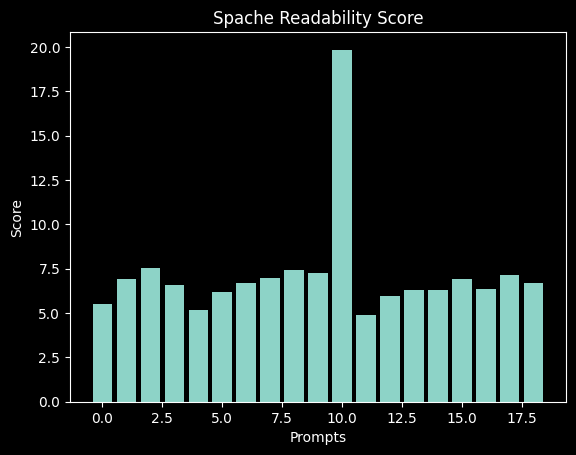

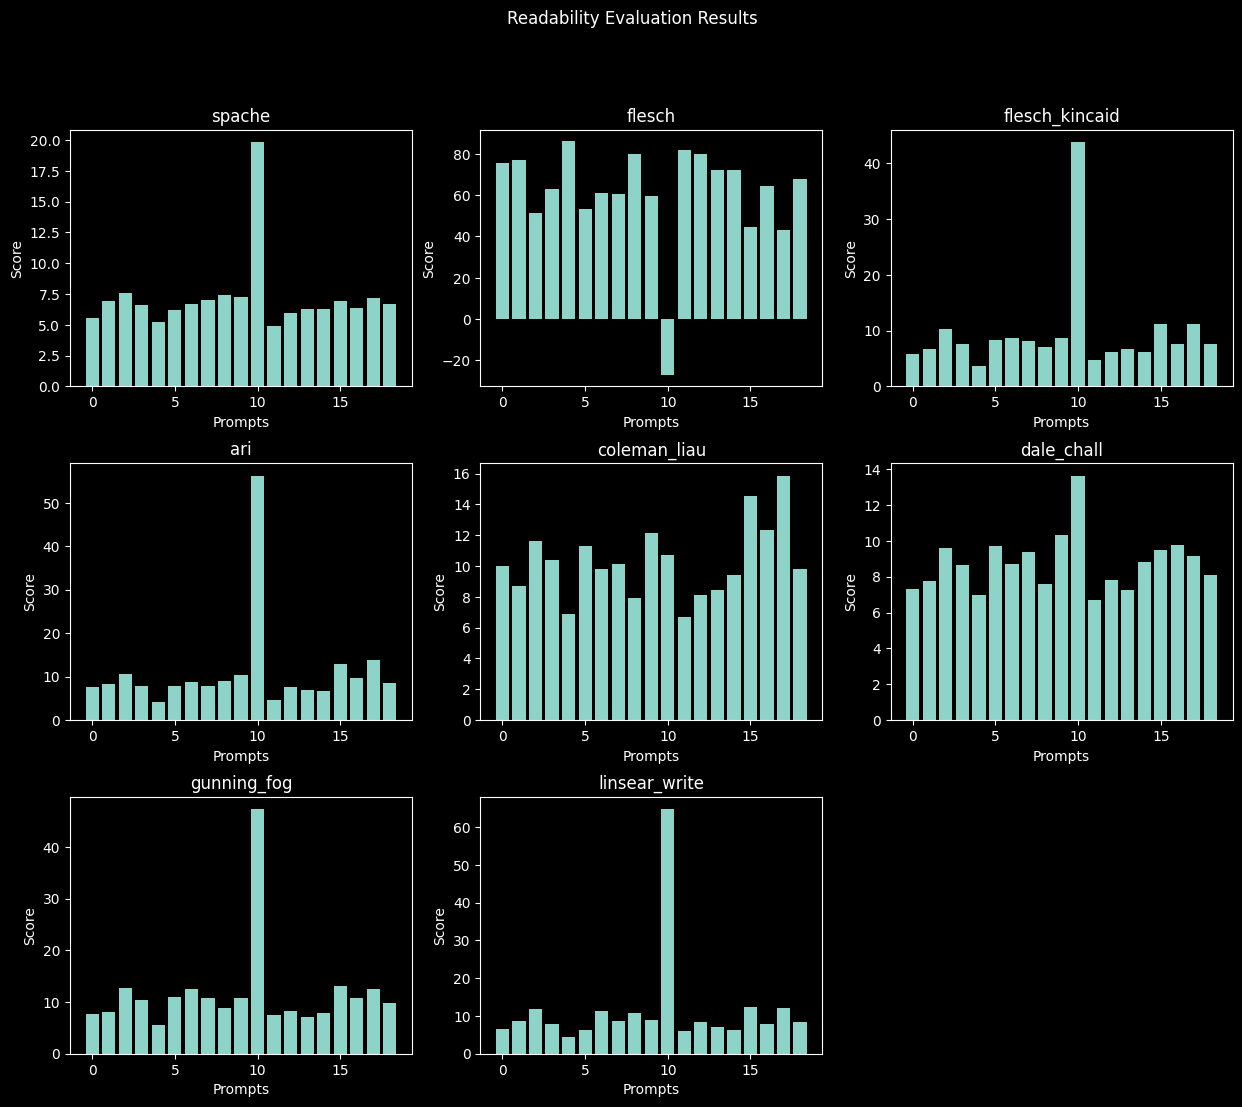

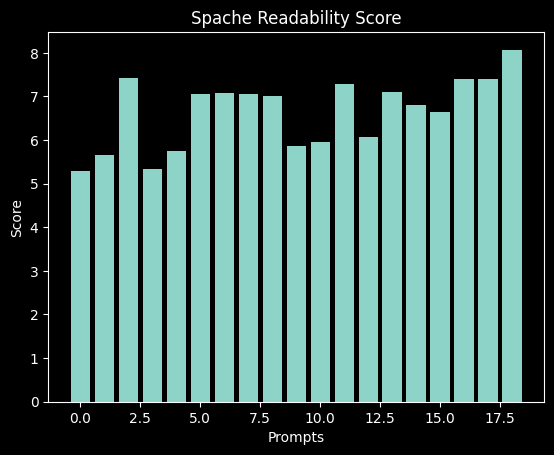

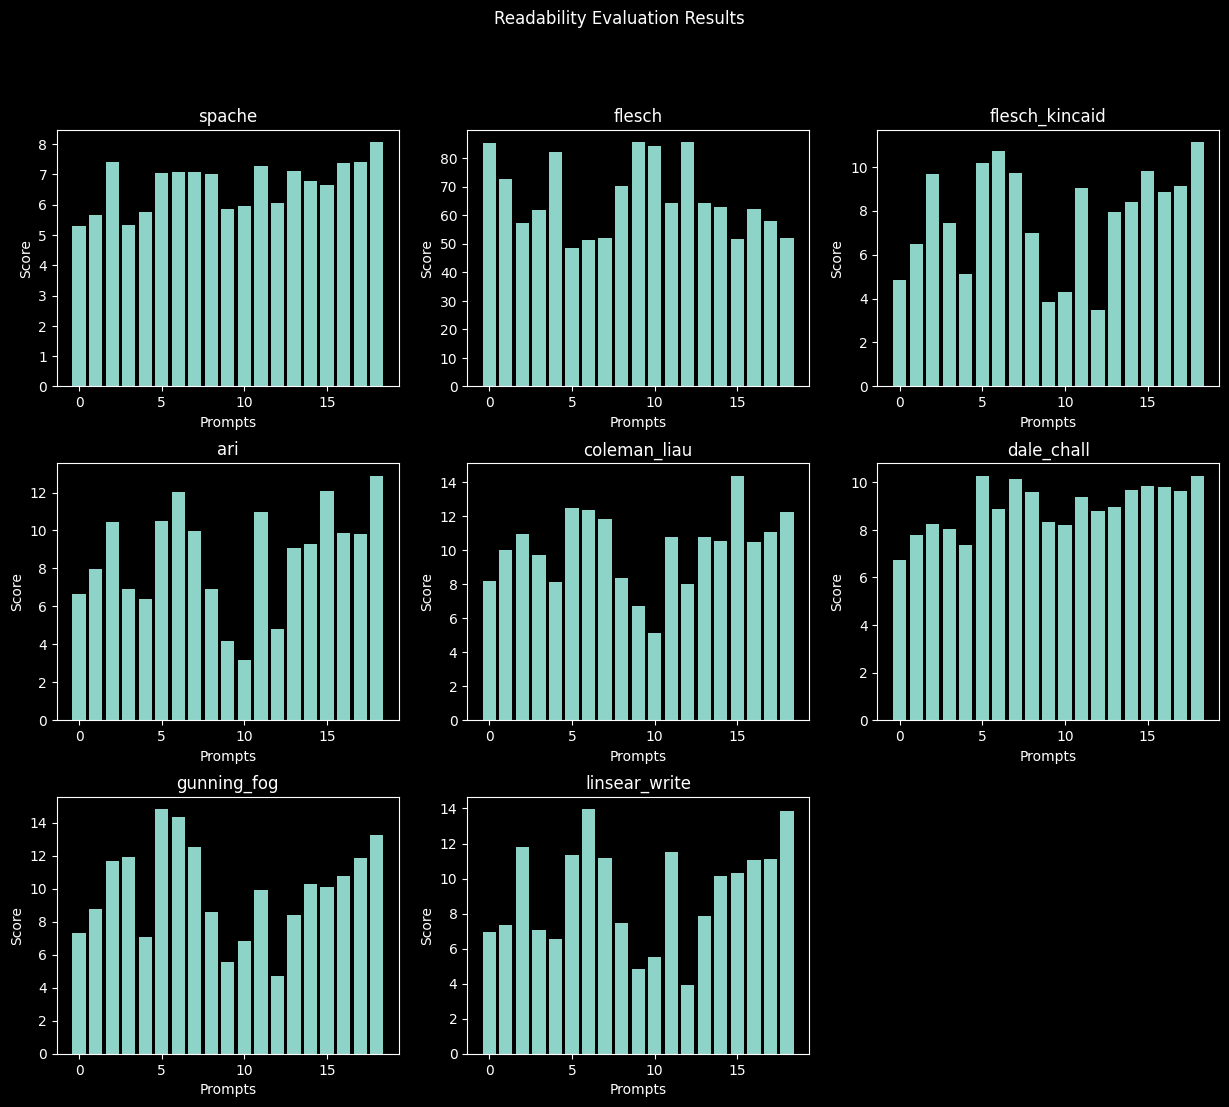

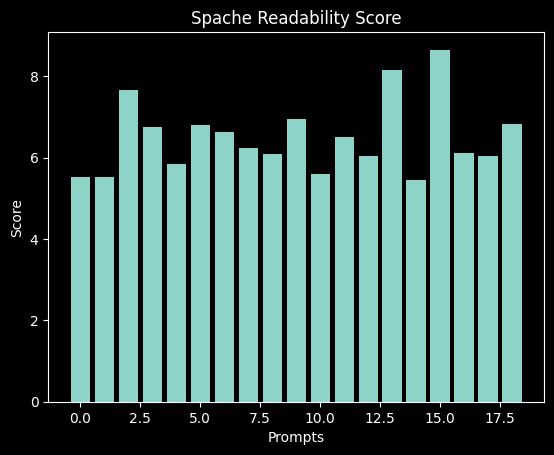

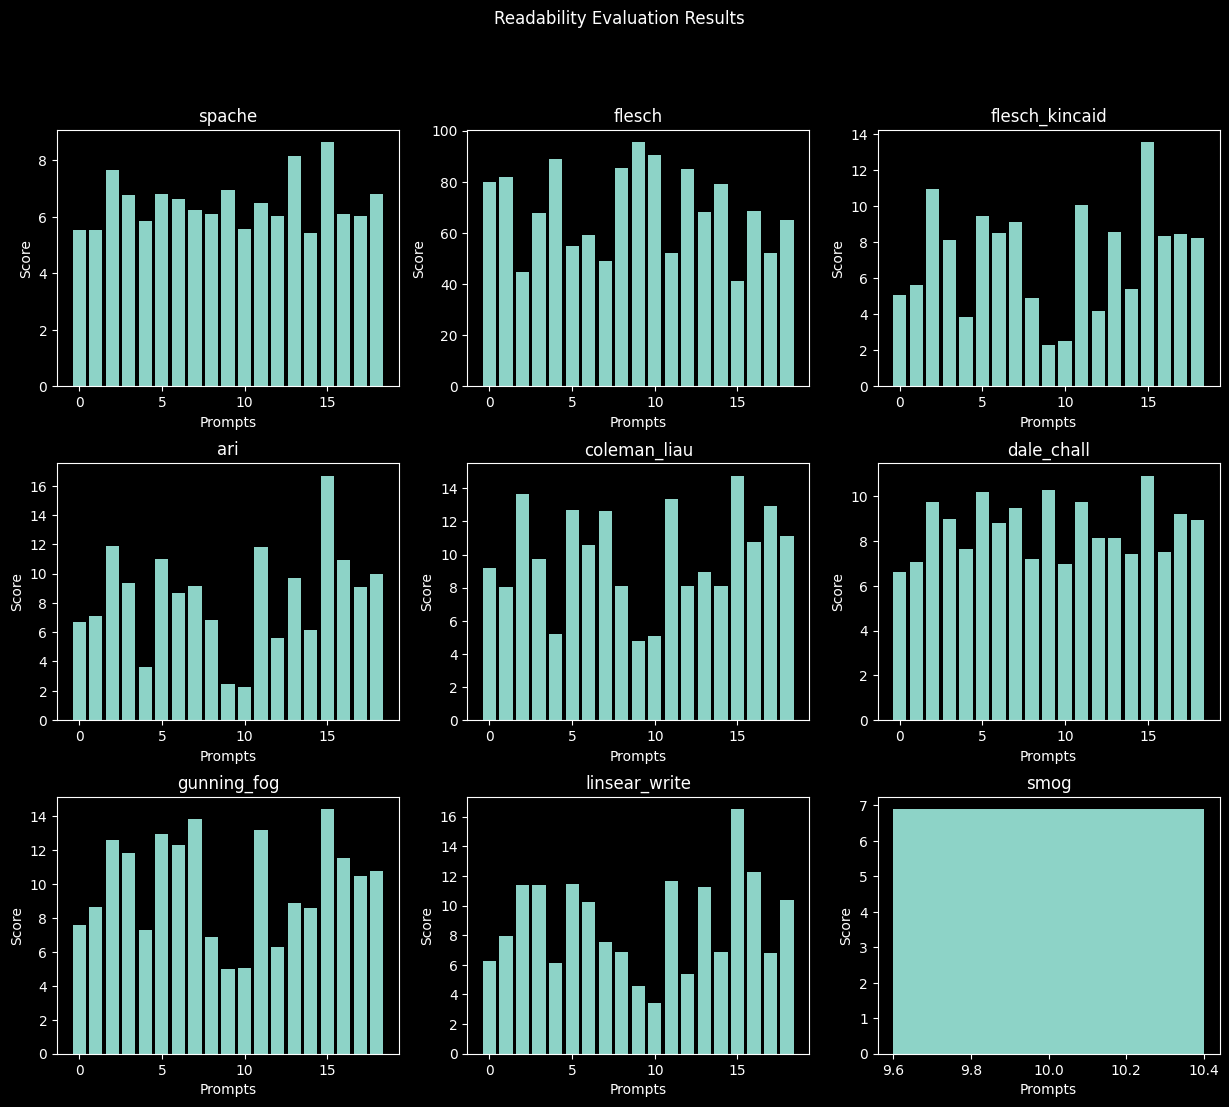

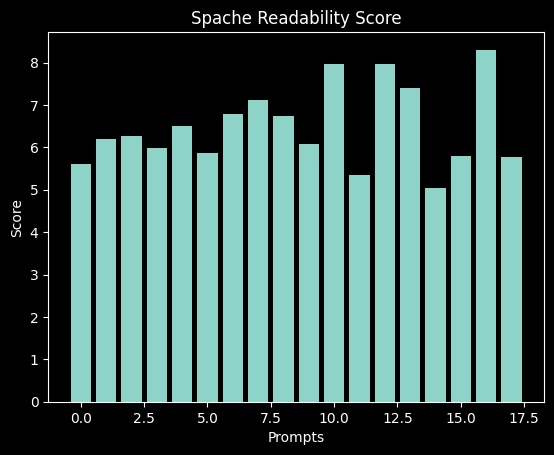

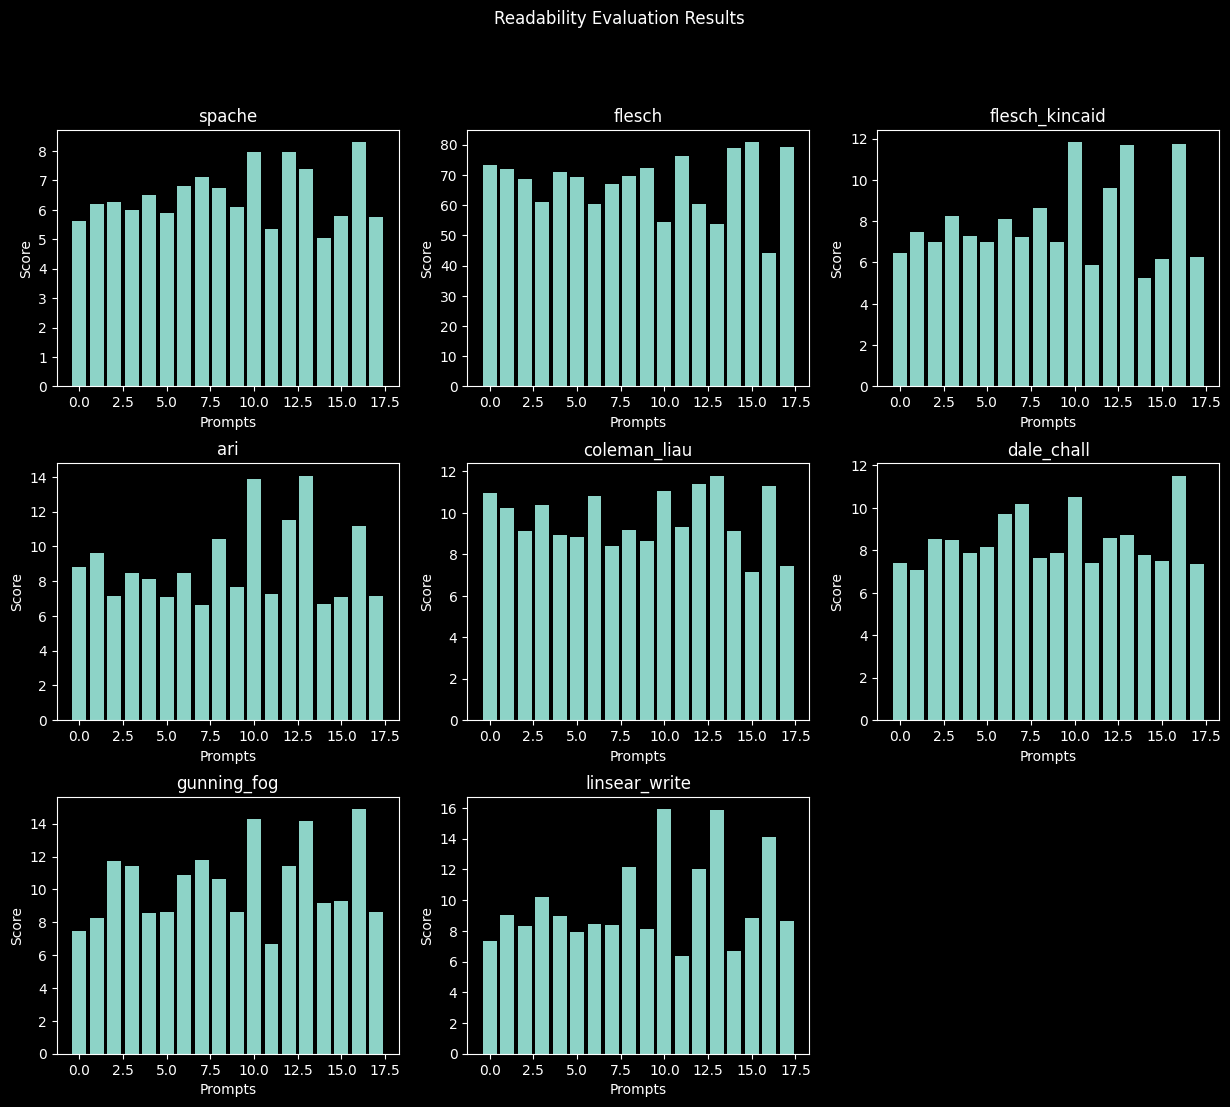

In [7]:
evaluation_william_ds = graph_results("evaluation_william.tsv")
evaluation_sophie_ds= graph_results("evaluation_sophie.tsv")
evaluation_reading_level_10_ds = graph_results("evaluation_reading_level_10.tsv")
evaluation_age_10_ds = graph_results("evaluation_age_10.tsv")

In [8]:
eval_dict = {
    "William": evaluation_william_ds,
    "Sophie": evaluation_sophie_ds,
    "Reading level 10": evaluation_reading_level_10_ds,
    "Age 10": evaluation_age_10_ds
}

In [ ]:
# https://stackoverflow.com/a/60270421
def bar_plot(ax, data, colors=None, total_width=0.8, single_width=1, legend=True):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: dictionary
        A dictionary containing the data we want to plot. Keys are the names of the
        data, the items is a list of the values.

        Example:
        data = {
            "x":[1,2,3],
            "y":[1,2,3],
            "z":[1,2,3],
        }

    colors : array-like, optional
        A list of colors which are used for the bars. If None, the colors
        will be the standard matplotlib color cyle. (default: None)

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.

    legend: bool, optional, default: True
        If this is set to true, a legend will be added to the axis.
    """

    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])

    # Draw legend if we need
    if legend:
        ax.legend(bars, data.keys())

NameError: name 'bar_plot' is not defined

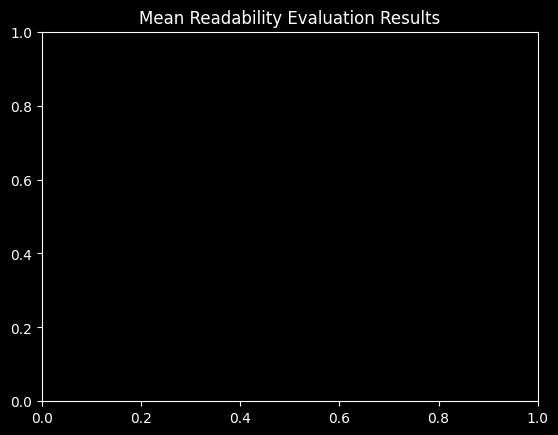

In [9]:
fig, ax = plt.subplots()

plt.title("Mean Readability Evaluation Results")

mean_scores = {}
for index, (name, ds) in enumerate(eval_dict.items()):
    for i, evaluator in enumerate(readability_evaluators):
        if evaluator not in ds.columns:
            continue
        if name not in mean_scores.keys():
            mean_scores[name] = []
        mean_scores[name].append((ds[evaluator].mean()))

bar_plot(ax, mean_scores, total_width=.8, single_width=.9)

plt.xticks(range(len(readability_evaluators)), readability_evaluators)

plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True
plt.xlabel("Metrics")
plt.ylabel("Mean Readability Scores")

In [ ]:
plt.title("Readability Evaluation Results")

plt.subplot(3, 1, 1)
for i, eval_ds_name, eval_ds in enumerate(eval_dict):
    mean_scores = []
    for i, evaluator in enumerate(readability_evaluators):
        if evaluator not in ds.columns:
            continue
        mean_scores.append(eval_ds[evaluator].desribe()["mean"])
    plt.bar(X_axis + (i*0.2) - ((i*0.4) * (i % 2 == 0)), eval_ds[evaluator], 0.4, label = eval_ds_name)


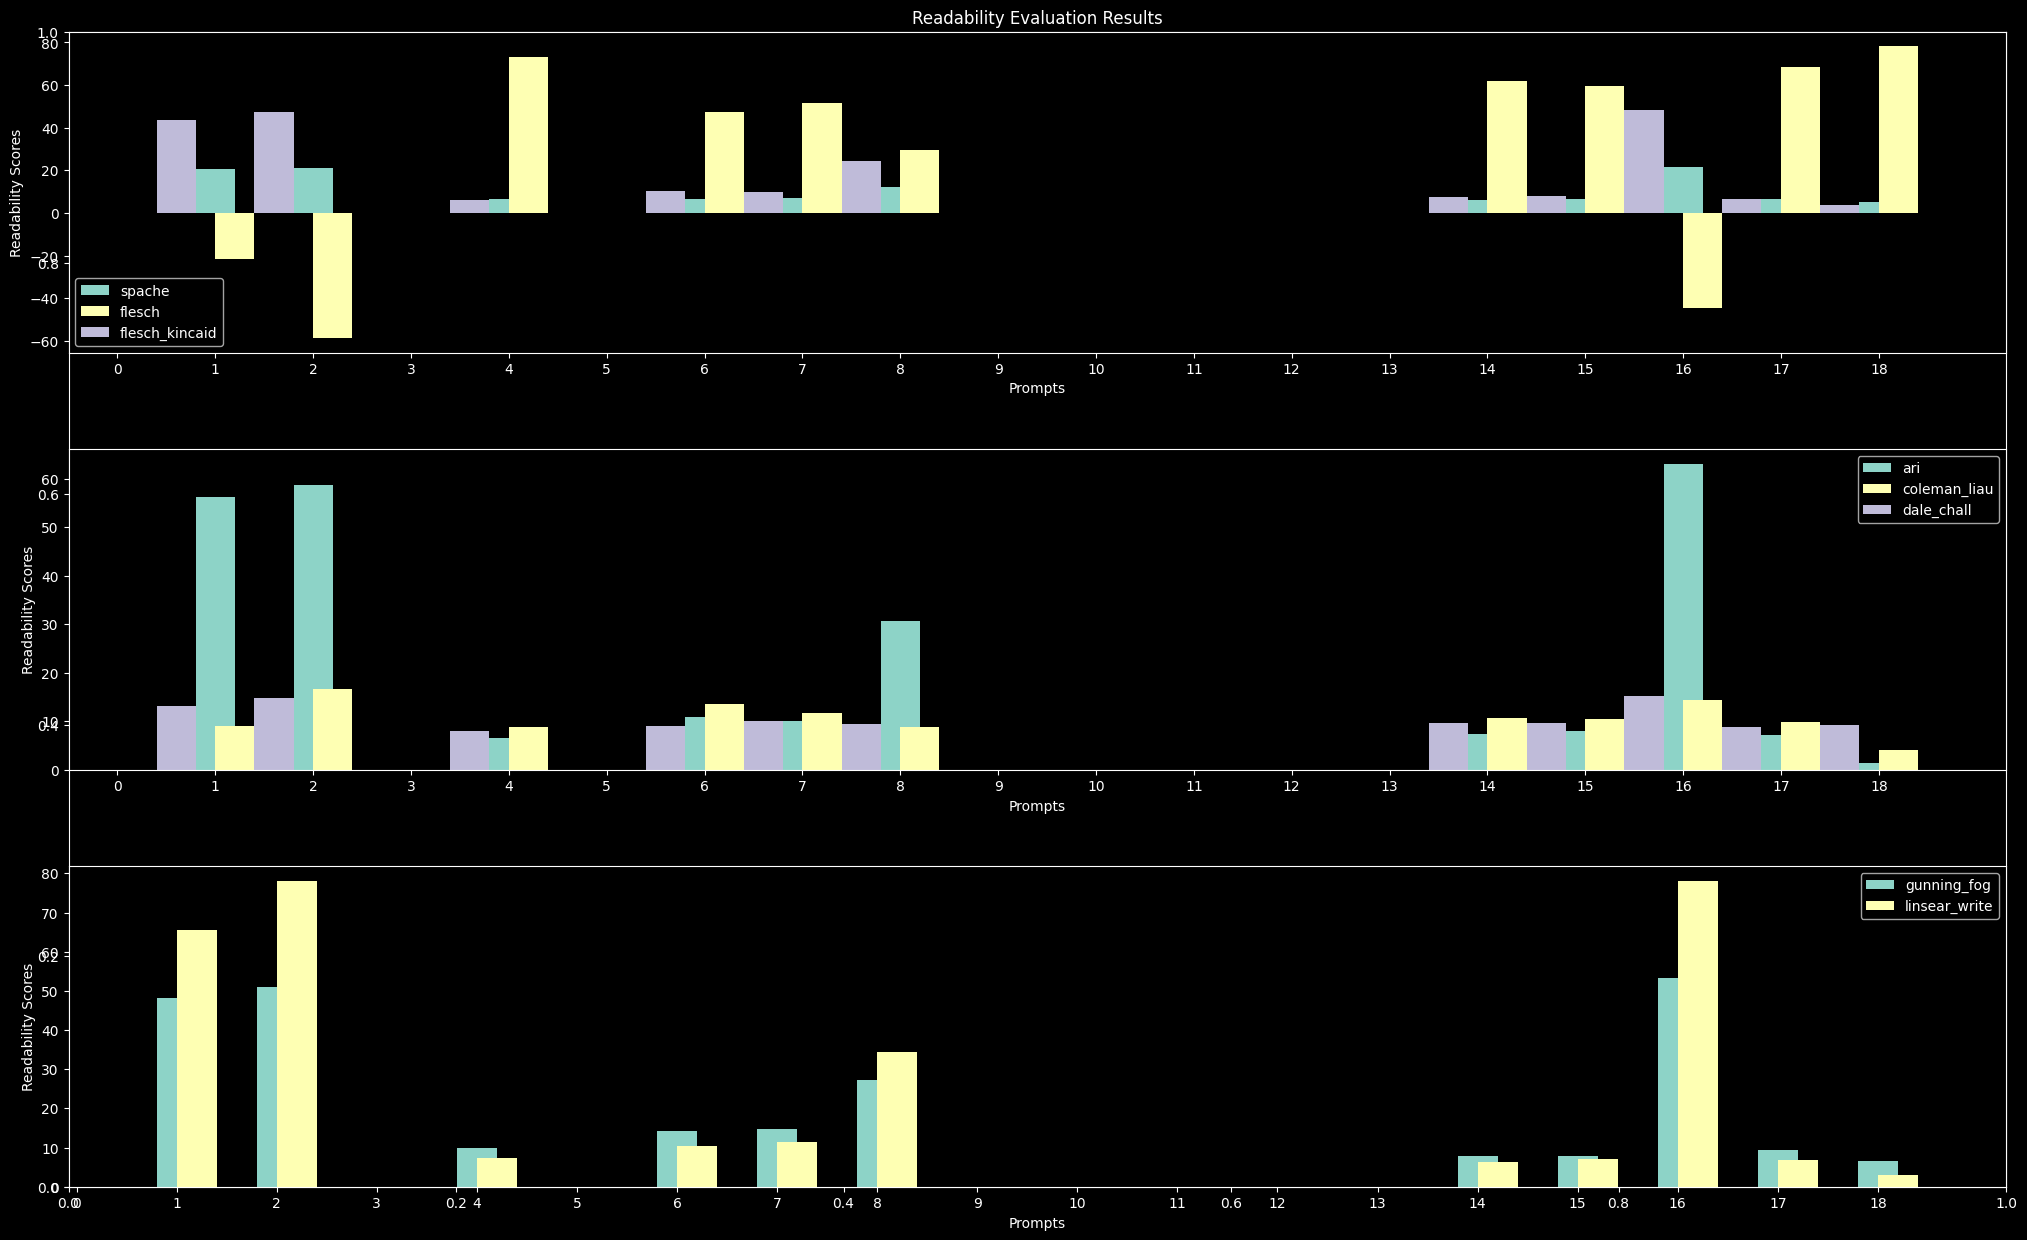

In [ ]:
X = range(eval_dict.index.stop)
X_axis = np.arange(eval_dict.index.stop)
plt.figure(figsize=(25, 15))
plt.title("Readability Evaluation Results")

plt.subplot(3, 1, 1)
for i, eval_ds_name, eval_ds in enumerate(eval_dict):
    mean_scores = []
    for i, evaluator in enumerate(readability_evaluators):
        if evaluator not in ds.columns:
            continue
        mean_scores.append(eval_ds[evaluator].desribe()["mean"])
    plt.bar(X_axis + (i*0.2) - ((i*0.4) * (i % 2 == 0)), eval_ds[evaluator], 0.4, label = eval_ds_name)

plt.subplots_adjust(hspace=0.3)

plt.xticks(X_axis, X)
plt.xlabel("Prompts")
plt.ylabel("Readability Scores")
plt.legend()

plt.subplot(3, 1, 2) 
for i, evaluator in enumerate(readability_evaluators[3:6]):
    if evaluator not in evaluation_ds.columns:
        continue
    plt.bar(X_axis + (i*0.2) - ((i*0.4) * (i % 2 == 0)), ds[evaluator], 0.4, label = evaluator)

plt.subplots_adjust(hspace=0.3)

plt.xticks(X_axis, X)
plt.xlabel("Prompts")
plt.ylabel("Readability Scores")
plt.legend()

plt.subplot(3, 1, 3)
for i, evaluator in enumerate(readability_evaluators[6:]):
    if evaluator not in evaluation_ds.columns:
        continue
    plt.bar(X_axis + (i*0.2) - ((i*0.4) * (i % 2 == 0)), ds[evaluator], 0.4, label = evaluator)

plt.subplots_adjust(hspace=0.3)

plt.xticks(X_axis, X)
plt.xlabel("Prompts")
plt.ylabel("Readability Scores")
plt.legend()

plt.show()


In [ ]:
for evaluator in readability_evaluators:
    if evaluator not in ds.columns:
        continue
    desc = ds[evaluator].describe()
    print(f"{evaluator}\t{desc['max']:.2f}\t{desc['min']:.2f}\t{desc['std']:.2f}\t{desc['mean']:.2f}")

spache	19.84	4.90	3.15	7.19
flesch	86.05	-26.92	24.76	61.35
flesch_kincaid	43.84	3.67	8.55	9.47
ari	56.26	4.15	11.20	11.01
coleman_liau	15.87	6.66	2.38	10.25
dale_chall	13.64	6.69	1.59	8.78
gunning_fog	47.31	5.55	8.89	11.72
linsear_write	64.75	4.48	13.08	11.52
